In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import sys, os, gc, types
import time
from subprocess import check_output
import tensorflow as tf

In [2]:
root_paths = [
    "/data/kaggle-wikipedia/data/",
    "/Users/jiayou/Dropbox/JuanCode/Kaggle/Wikipedia/data/",
    "/Users/jiayou/Dropbox/Documents/JuanCode/Kaggle/Wikipedia/data/"
]
root = None
for p in root_paths:
    if os.path.exists(p):
        root = p
        break
print(check_output(["ls", root]).decode("utf8"))

date_all_df.pkl
date_df.csv
key_1.csv
key_1_modified.csv
key_1_modified.pkl
median_49.csv
median_weekday.csv
median_weekday_fix.csv
median_weekend.csv
page_df.csv
page_df.pkl
page_ohe.csv
page_ohe.pkl
sample_submission_1.csv
spider.txt
test_date_df.csv
train_1.csv



In [3]:
train = pd.read_csv(root + 'train_1.csv')
train.fillna(0, inplace = True)

In [4]:
data = train.iloc[:,1:].values

# 1. percentile scaler
# scale = np.percentile(data, 98, axis=1)
# data = data / np.maximum(1, scale.reshape((data.shape[0], 1))) - 0.5

# 2. global std scaler
# sc = StandardScaler()
# sc.fit(data.reshape((-1, 1)))
# data = sc.transform(data.reshape((-1, 1))).reshape(data.shape)

# 3. per page log1p + std scaler
# data = np.log1p(data)

In [5]:
fpage = pd.read_pickle(os.path.join(root, 'page_df.pkl'))
fdate = pd.read_pickle(os.path.join(root, 'date_all_df.pkl'))

fdate.isweekday = fdate.isweekday.astype(np.int32)
fdate.drop(['date', 'date_str'], axis=1, inplace=True)

fpage_depth = {}
for c in ['domain', 'access', 'agent']:
    values = fpage[c].unique()
    n = len(values)
    fpage_depth[c] = n
    idx_lookup = {values[i]: i for i in range(n)}
    def v2idx(v):
        return idx_lookup[v]
    fpage[c] = np.vectorize(v2idx)(fpage[c])
fpage.drop(['Page'], axis=1, inplace=True)

In [6]:
from collections import deque
from datetime import datetime
import logging
import os, imp
import pprint as pp

import numpy as np
import tensorflow as tf

def shape(tensor, dim=None):
    """Get tensor shape/dimension as list/int"""
    if dim is None:
        return tensor.shape.as_list()
    else:
        return tensor.shape.as_list()[dim]

class TFBaseModel(object):

    """Interface containing some boilerplate code for training tensorflow models.
    Subclassing models must implement self.calculate_loss(), which returns a tensor for the batch loss.
    Code for the training loop, parameter updates, checkpointing, and inference are implemented here and
    subclasses are mainly responsible for building the computational graph beginning with the placeholders
    and ending with the loss tensor.
    Args:
        reader: Class with attributes train_batch_generator, val_batch_generator, and test_batch_generator
            that yield dictionaries mapping tf.placeholder names (as strings) to batch data (numpy arrays).
        batch_size: Minibatch size.
        learning_rate: Learning rate.
        optimizer: 'rms' for RMSProp, 'adam' for Adam, 'sgd' for SGD
        grad_clip: Clip gradients elementwise to have norm at most equal to grad_clip.
        regularization_constant:  Regularization constant applied to all trainable parameters.
        early_stopping_steps:  Number of steps to continue training after validation loss has
            stopped decreasing.
        warm_start_init_step:  If nonzero, model will resume training a restored model beginning
            at warm_start_init_step.
        num_restarts:  After validation loss plateaus, the best checkpoint will be restored and the
            learning rate will be halved.  This process will repeat num_restarts times.
        enable_parameter_averaging:  If true, model saves exponential weighted averages of parameters
            to separate checkpoint file.
        min_steps_to_checkpoint:  Model only saves after min_steps_to_checkpoint training steps
            have passed.
        log_interval:  Train and validation accuracies are logged every log_interval training steps.
        loss_averaging_window:  Train/validation losses are averaged over the last loss_averaging_window
            training steps.
        num_validation_batches:  Number of batches to be used in validation evaluation at each step.
        log_dir: Directory where logs are written.
        checkpoint_dir: Directory where checkpoints are saved.
        prediction_dir: Directory where predictions/outputs are saved.
    """

    def __init__(
        self,
        reader,
        batch_size=128,
        num_training_steps=20000,
        learning_rate=.01,
        optimizer='adam',
        grad_clip=5,
        regularization_constant=0.0,
        early_stopping_steps=3000,
        warm_start_init_step=0,
        num_restarts=None,
        enable_parameter_averaging=False,
        min_steps_to_checkpoint=100,
        log_interval=20,
        loss_averaging_window=100,
        num_validation_batches=1,
        work_dir='tf-data',
        name='nn'
    ):

        self.reader = reader
        self.batch_size = batch_size
        self.num_training_steps = num_training_steps
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.grad_clip = grad_clip
        self.regularization_constant = regularization_constant
        self.warm_start_init_step = warm_start_init_step
        self.early_stopping_steps = early_stopping_steps if early_stopping_steps is not None else np.inf
        self.enable_parameter_averaging = enable_parameter_averaging
        self.num_restarts = num_restarts
        self.min_steps_to_checkpoint = min_steps_to_checkpoint
        self.log_interval = log_interval
        self.num_validation_batches = num_validation_batches
        self.loss_averaging_window = loss_averaging_window
        self.name = name

        self.log_dir = os.path.join(work_dir, 'logs')
        self.prediction_dir = os.path.join(work_dir, 'predictions')
        self.checkpoint_dir = os.path.join(work_dir, 'checkpoints')
        if self.enable_parameter_averaging:
            self.checkpoint_dir_averaged = os.path.join(work_dir, 'checkpoints-avg')

        self.init_logging(self.log_dir)
        self.logger.info('\nNetwork hyper-parameters:\n{}'.format(pp.pformat(self.__dict__)))
        self.reader.describe(self.logger)

        self.graph = self.build_graph()
        self.session = tf.Session(graph=self.graph)
        print('Built graph')

    def calculate_loss(self):
        raise NotImplementedError('subclass must implement this')

    def fit(self, yield_interval=None):
        with self.session.as_default():

            if self.warm_start_init_step:
                self.restore(self.warm_start_init_step)
                step = self.warm_start_init_step
            else:
                self.session.run(self.init)
                step = 0

            train_generator = self.reader.train_batch_generator(self.batch_size)
            val_generator = self.reader.val_batch_generator(self.num_validation_batches*self.batch_size)

            train_loss_history = deque(maxlen=self.loss_averaging_window)
            val_loss_history = deque(maxlen=self.loss_averaging_window)
            
            smoothed_tlh = []
            smoothed_vlh = []

            best_validation_loss, best_validation_tstep = float('inf'), None
            restarts = 0

            while step < self.num_training_steps:
                
                if yield_interval is not None and step % yield_interval == 0:
                    plt.figure(figsize=(20, 5))
                    plt.plot(smoothed_tlh, ':')
                    plt.plot(smoothed_vlh, 'g')
                    plt.show()
                    yield step

                # validation evaluation
                val_batch_df = next(val_generator)
                val_feed_dict = {
                    getattr(self, placeholder_name, None): data
                    for placeholder_name, data in val_batch_df.items() if hasattr(self, placeholder_name)
                }

                val_feed_dict.update({self.learning_rate_var: self.learning_rate})
                [val_loss] = self.session.run(
                    fetches=[self.loss],
                    feed_dict=val_feed_dict
                )
                val_loss_history.append(val_loss)

                # train step
                train_batch_df = next(train_generator)
                train_feed_dict = {
                    getattr(self, placeholder_name, None): data
                    for placeholder_name, data in train_batch_df.items() if hasattr(self, placeholder_name)
                }

                train_feed_dict.update({self.learning_rate_var: self.learning_rate})
                train_loss, _ = self.session.run(
                    fetches=[self.loss, self.step],
                    feed_dict=train_feed_dict
                )
                train_loss_history.append(train_loss)

                if step % self.log_interval == 0 or step + 1 == self.num_training_steps:
                    avg_train_loss = sum(train_loss_history) / len(train_loss_history)
                    avg_val_loss = sum(val_loss_history) / len(val_loss_history)
                    smoothed_tlh.append(avg_train_loss)
                    smoothed_vlh.append(avg_val_loss)
                    metric_log = (
                        "[[step {:>8}]]     "
                        "[[train]]     loss: {:<12}     "
                        "[[val]]     loss: {:<12}"
                    ).format(step, round(avg_train_loss, 8), round(avg_val_loss, 8))
                    self.logger.info(metric_log)

                    if step > self.min_steps_to_checkpoint and avg_val_loss < best_validation_loss:
                        best_validation_loss = avg_val_loss
                        best_validation_tstep = step
                        self.save(step)
                        if self.enable_parameter_averaging:
                            self.save(step, averaged=True)

                    if best_validation_tstep is not None and step - best_validation_tstep >= self.early_stopping_steps:

                        if self.num_restarts is None or restarts >= self.num_restarts:
                            self.logger.info('Early stopping')
                            break

                        if restarts < self.num_restarts:
                            self.logger.info('')
                            self.restore(best_validation_tstep)
                            self.learning_rate /= 2.0
#                             self.early_stopping_steps /= 2
                            step = best_validation_tstep
                            train_loss_history = deque(maxlen=self.loss_averaging_window)
                            val_loss_history = deque(maxlen=self.loss_averaging_window)
                            restarts += 1
                            self.logger.info(
                                'Half learning rate to {} and restore step {}'.format(self.learning_rate, step)
                            )

                step += 1

            if step <= self.min_steps_to_checkpoint:
                best_validation_tstep = step
                self.save(step)
                if self.enable_parameter_averaging:
                    self.save(step, averaged=True)

            self.logger.info('Training ended')
            self.logger.info(
                'Best validation loss of {} at training step {}'.format(
                    round(best_validation_loss, 8), 
                    best_validation_tstep
                )
            )

    def predict(self, batch_size=128, num_batches=None):
        if not os.path.isdir(self.prediction_dir):
            os.makedirs(self.prediction_dir)

        preds = {}
        if hasattr(self, 'prediction_tensors'):
            prediction_dict = {tensor_name: [] for tensor_name in self.prediction_tensors}

            test_generator = self.reader.test_batch_generator(batch_size)
            for i, test_batch_df in enumerate(test_generator):
                test_feed_dict = {
                    getattr(self, placeholder_name, None): data
                    for placeholder_name, data in test_batch_df.items() if hasattr(self, placeholder_name)
                }

                tensor_names, tf_tensors = zip(*self.prediction_tensors.items())
                np_tensors = self.session.run(
                    fetches=tf_tensors,
                    feed_dict=test_feed_dict
                )
                for tensor_name, tensor in zip(tensor_names, np_tensors):
                    prediction_dict[tensor_name].append(tensor)
                    
                if num_batches is not None and i + 1 == num_batches:
                    break

            for tensor_name, tensor in prediction_dict.items():
                np_tensor = np.concatenate(tensor, 0)
                preds[tensor_name] = np_tensor
                save_file = os.path.join(self.prediction_dir, '{}.npy'.format(tensor_name))
                self.logger.info('Saving {} with shape {} to {}'.format(tensor_name, np_tensor.shape, save_file))
                np.save(save_file, np_tensor)

        if hasattr(self, 'parameter_tensors'):
            for tensor_name, tensor in self.parameter_tensors.items():
                np_tensor = tensor.eval(self.session)

                save_file = os.path.join(self.prediction_dir, '{}.npy'.format(tensor_name))
                self.logger.info('Saving {} with shape {} to {}'.format(tensor_name, np_tensor.shape, save_file))
                np.save(save_file, np_tensor)

        return preds

    def save(self, step, averaged=False):
        saver = self.saver_averaged if averaged else self.saver
        checkpoint_dir = self.checkpoint_dir_averaged if averaged else self.checkpoint_dir
        if not os.path.isdir(checkpoint_dir):
            self.logger.info('creating checkpoint directory {}'.format(checkpoint_dir))
            os.mkdir(checkpoint_dir)

        model_path = os.path.join(checkpoint_dir, 'model')
        self.logger.info('saving model to {}'.format(model_path))
        saver.save(self.session, model_path, global_step=step)

    def restore(self, step=None, averaged=False):
        saver = self.saver_averaged if averaged else self.saver
        checkpoint_dir = self.checkpoint_dir_averaged if averaged else self.checkpoint_dir
        if not step:
            model_path = tf.train.latest_checkpoint(checkpoint_dir)
            self.logger.info('Restoring model parameters from {}'.format(model_path))
            saver.restore(self.session, model_path)
        else:
            model_path = os.path.join(
                checkpoint_dir, 'model{}-{}'.format('_avg' if averaged else '', step)
            )
            self.logger.info('Restoring model from {}'.format(model_path))
            saver.restore(self.session, model_path)

    def init_logging(self, log_dir):
        if not os.path.isdir(log_dir):
            os.makedirs(log_dir)
        
        logger = logging.getLogger(
            '{}.{}'.format(
                type(self).__name__, 
                datetime.now().strftime('%Y-%m-%d.%H-%M-%S.%f')
            )
        )
        logger.setLevel(logging.INFO)
        fmtr = logging.Formatter(
            fmt='[[%(asctime)s]] %(message)s',
            datefmt='%m/%d/%Y %I:%M:%S %p'
        )

        h = logging.StreamHandler(stream=sys.stdout)
        h.setFormatter(fmtr)
        logger.addHandler(h)
        
        date_str = datetime.now().strftime('%Y-%m-%d_%H-%M')
        log_file = 'log.{}.{}.{}.txt'.format(type(self).__name__, self.name, date_str)
        h = logging.FileHandler(filename=os.path.join(log_dir, log_file))
        h.setFormatter(fmtr)
        logger.addHandler(h)
        
        self.logger = logger

    def update_parameters(self, loss):
        self.global_step = tf.Variable(0, trainable=False)
        self.learning_rate_var = tf.Variable(0.0, trainable=False)

        if self.regularization_constant != 0:
            l2_norm = tf.reduce_sum([tf.sqrt(tf.reduce_sum(tf.square(param))) for param in tf.trainable_variables()])
            loss = loss + self.regularization_constant*l2_norm

        optimizer = self.get_optimizer(self.learning_rate_var)
        grads = optimizer.compute_gradients(loss)
        clipped = [
            (g if g is None else tf.clip_by_value(g, -self.grad_clip, self.grad_clip), v_) for g, v_ in grads
        ]

        step = optimizer.apply_gradients(clipped, global_step=self.global_step)

        if self.enable_parameter_averaging:
            maintain_averages_op = self.ema.apply(tf.trainable_variables())
            with tf.control_dependencies([step]):
                self.step = tf.group(maintain_averages_op)
        else:
            self.step = step

    def log_parameters(self):
        self.logger.info(
            (
                '\n\n'
                'All parameters:\n{}\n'
                'Trainable parameters:\n{}\n'
                'Trainable parameter count: {}\n'
            ).format(
                pp.pformat([(var.name, shape(var)) for var in tf.global_variables()]),
                pp.pformat([(var.name, shape(var)) for var in tf.trainable_variables()]),
                str(np.sum(np.prod(shape(var)) for var in tf.trainable_variables())),
            )
        )

    def get_optimizer(self, learning_rate):
        if self.optimizer == 'adam':
            return tf.train.AdamOptimizer(learning_rate)
        elif self.optimizer == 'gd':
            return tf.train.GradientDescentOptimizer(learning_rate)
        elif self.optimizer == 'rms':
            return tf.train.RMSPropOptimizer(learning_rate, decay=0.95, momentum=0.9)
        else:
            assert False, 'optimizer must be adam, gd, or rms'

    def build_graph(self):
        with tf.Graph().as_default() as graph:
            self.ema = tf.train.ExponentialMovingAverage(decay=0.995)

            self.loss = self.calculate_loss()
            self.update_parameters(self.loss)
            self.log_parameters()

            self.saver = tf.train.Saver(max_to_keep=1)
            if self.enable_parameter_averaging:
                self.saver_averaged = tf.train.Saver(self.ema.variables_to_restore(), max_to_keep=1)

            self.init = tf.global_variables_initializer()

            return graph

In [7]:
class DataReader():
    def __init__(
        self, data, fpage, fdate, 
        min_train_days, max_train_days, train_predict_days, train_loss_days, 
        min_val_days, max_val_days, val_predict_days, val_loss_days,
        train_val_split_day, predict_days, 
        seed=923
    ):
        self.data = data
        self.seed = seed
        self.days = self.data.shape[1]
        
        self.train_val_split_day = train_val_split_day
        self.max_train_days = max_train_days
        self.min_train_days = min_train_days
        self.train_predict_days = train_predict_days
        self.train_loss_days = train_loss_days
        self.min_val_days = min_val_days
        self.max_val_days = max_val_days 
        self.val_predict_days = val_predict_days 
        self.val_loss_days = val_loss_days
        self.predict_days = predict_days
        
        self.domain = fpage.domain.values
        self.access = fpage.access.values
        self.agent = fpage.agent.values
        
        self.dayofweek = fdate.dayofweek.values
        self.isweekday = fdate.isweekday.values
        self.month = fdate.month.values
        
    def describe(self, logger):
        logger.info('')
        logger.info('Data dimensions:')
        logger.info('    [[data]] {}'.format(self.data.shape))
        logger.info('Split seed = {}'.format(self.seed))
        logger.info('')

    def train_batch_generator(self, batch_size):
        return self.batch_generator(
            self.data,
            batch_size=batch_size,
            start_day = 0,
            total_days = self.train_val_split_day,
            min_days = self.min_train_days,
            max_days = self.max_train_days,
            predict_days = self.train_predict_days,
            loss_days = self.train_loss_days,
        )

    def val_batch_generator(self, batch_size):
        return self.batch_generator(
            self.data,
            batch_size=batch_size,
            start_day = self.train_val_split_day,
            total_days = self.days - self.train_val_split_day,
            min_days = self.min_val_days,
            max_days = self.max_val_days,
            predict_days = self.val_predict_days,
            loss_days = self.val_loss_days,
        )
    
    def scale(self, data, given_days=None):
        if given_days is None:
            given_days = data.shape[1]
        sc = StandardScaler()
        sc.fit(data[:,:given_days].T)
        return (sc.transform(data.T).T, sc)

    def test_batch_generator(self, batch_size):
        start = 0
        n = self.data.shape[0]
        while start < n:
            batch = {}
            idx = [i for i in range(start, min(start + batch_size, n))]
            batch['data'], batch['scaler'] = self.scale(self.data[idx, :])
            batch['given_days'] = self.days
            batch['no_loss_days'] = self.days
            batch['days'] = self.days + self.predict_days
            
            batch['dayofweek'] = self.dayofweek
            batch['isweekday'] = self.isweekday
            batch['month'] = self.month
            
            batch['domain'] = self.domain[idx]
            batch['agent'] = self.agent[idx]
            batch['access'] = self.access[idx]
            
            yield batch
            
            start += batch_size

    def batch_generator(self, data, batch_size, start_day, total_days, max_days, min_days, predict_days, loss_days):
        while True:
            idx = np.random.randint(0, data.shape[0], [batch_size])
            start = np.random.randint(start_day, start_day + total_days - min_days + 1)
            days = np.random.randint(min_days, min(max_days, start_day + total_days - start) + 1)
            days_idx = [i for i in range(start, start + days)]
            given_days = days - predict_days
            no_loss_days = days - loss_days
            
            batch = {}
            batch['data'], batch['scaler'] = self.scale(data[idx, :][:, days_idx], no_loss_days)
            
            batch['given_days'] = given_days
            batch['no_loss_days'] = no_loss_days
            batch['days'] = days
            
            batch['dayofweek'] = self.dayofweek[days_idx]
            batch['isweekday'] = self.isweekday[days_idx]
            batch['month'] = self.month[days_idx]
            
            batch['domain'] = self.domain[idx]
            batch['agent'] = self.agent[idx]
            batch['access'] = self.access[idx]
            
            yield batch

In [17]:
class WikiRNN(TFBaseModel):

    def __init__(self, state_size, keep_prob=1, **kwargs):
        self.state_size = state_size
        self.keep_prob = keep_prob
        super(type(self), self).__init__(**kwargs)

    def calculate_loss(self):
        self.data = tf.placeholder(tf.float32, name='data')
        self.given_days = tf.placeholder(tf.int32, name='given_days')
        self.no_loss_days = tf.placeholder(tf.int32, name='no_loss_days')
        self.days = tf.placeholder(tf.int32, name='days')
        batch_size = tf.shape(self.data)[0]
        
#         batch_size = tf.Print(batch_size, [self.data], "data", summarize=1000)
        
        # Features
        self.dayofweek = tf.placeholder(tf.int32, [None])
        self.isweekday = tf.placeholder(tf.int32, [None])
        self.month = tf.placeholder(tf.int32, [None])
        
        self.domain = tf.placeholder(tf.int32, [None])
        self.agent = tf.placeholder(tf.int32, [None])
        self.access = tf.placeholder(tf.int32, [None])
        
        dayofweek_oh = tf.one_hot(self.dayofweek, 7)
        isweekday_oh = tf.one_hot(self.isweekday, 2)
        month = tf.one_hot(self.month, 13)
        
        domain = tf.one_hot(self.domain, 9)
        agent = tf.one_hot(self.agent, 2)
        access = tf.one_hot(self.access, 3)
        
        date_features = tf.concat(
            [
                dayofweek_oh,
                isweekday_oh,
                month,
            ], 
            axis=1,
        )
        date_features = tf.tile(tf.expand_dims(date_features, 0), [batch_size, 1, 1])
        
        page_features = tf.concat(
            [
                domain,
                agent,
                access,
            ], 
            axis=1,
        )
        page_features = tf.tile(tf.expand_dims(page_features, 1), [1, self.days, 1])
        
        features = tf.concat([date_features, page_features], axis=2)
        
        cells = []
        for i in range(len(self.state_size)):
            cells.append(
                tf.contrib.rnn.DropoutWrapper(
                    tf.contrib.rnn.LSTMCell(
                        self.state_size[i],
                    ),
                    output_keep_prob=self.keep_prob,
                ),
            )
        cell = tf.nn.rnn_cell.MultiRNNCell(cells)
        
        # ([batch_size, state_size])
        state = cell.zero_state(tf.shape(self.data)[0], dtype=tf.float32)
        # [batch_size, 1]
        last_output = tf.zeros([tf.shape(self.data)[0], 1], dtype=tf.float32)
        
        loss = tf.constant(0, dtype=tf.float32)
        step = tf.constant(0, dtype=tf.int32)
        output_ta = tf.TensorArray(size=self.days, dtype=tf.float32)
        
        def cond(last_output, state, loss, step, output_ta):
            return step < self.days
        
        def body(last_output, state, loss, step, output_ta):
            inp = tf.concat(
                [
                    last_output,
                    features[:, step, :],
                ],
                axis=1
            )
            
#             inp = tf.cond(
#                 step < 10,
#                 lambda: tf.Print(inp, [step, inp], "input", summarize=200*47),
#                 lambda: inp,
#             )
            
            output, state = cell(inp, state)
            output = tf.layers.dense(
                output,
                1,
                name='dense-top'
            )
            output_ta = output_ta.write(step, tf.transpose(output))
            
            last_output = tf.cond(
                step < self.given_days,
                lambda: tf.expand_dims(self.data[:,step], 1),
                lambda: output,
            )
            last_output.set_shape([None, 1])
            
#             true = tf.maximum(1e-8, self.data[:,step])            
            true = tf.expand_dims(self.data[:,step], 1)
#             true = tf.Print(true, [true], 'true.shape', summarize=1000)
#             output = tf.Print(output, [output], 'output.shape', summarize=1000)
            loss = tf.cond(
                step >= self.no_loss_days,
#                 lambda: loss + tf.reduce_mean(2 * tf.abs(true - output) / tf.maximum(1e-6, true + output)),
                lambda: loss + tf.reduce_mean(tf.abs(true - output)),
                lambda: loss
            )
            loss.set_shape([])
            
            return (last_output, state, loss, step + 1, output_ta)
        
        _, _, loss, _, output_ta = tf.while_loop(
            cond=cond,
            body=body,
            loop_vars=(last_output, state, loss, step, output_ta)
        )
        
        self.preds = tf.transpose(output_ta.concat())
        self.prediction_tensors = {
            'preds': self.preds
        }
        
        loss = loss / tf.cast(self.days - self.no_loss_days, tf.float32)
#         loss = tf.Print(loss, [loss, self.data[:, -1], self.preds[:, -1]], "Loss = ")
        return loss

    def predict(self, batch_size=1000, num_batches=None):
        preds = []
        test_generator = self.reader.test_batch_generator(batch_size)
        for i, test_batch_df in enumerate(test_generator):
            test_feed_dict = {
                getattr(self, placeholder_name, None): data
                for placeholder_name, data in test_batch_df.items() if hasattr(self, placeholder_name)
            }

            batch_preds = self.session.run(
                fetches=[self.preds],
                feed_dict=test_feed_dict
            )[0]
            
            scaler = test_batch_df['scaler']
            batch_preds = scaler.inverse_transform(batch_preds.T).T
            
            preds.append(batch_preds)
            print('batch {} processed'.format(i))

        return np.concatenate(preds, axis=0)


[[09/04/2017 06:20:20 PM]] 
Network hyper-parameters:
{'batch_size': 1,
 'checkpoint_dir': './tf-data/checkpoints',
 'early_stopping_steps': 2000000,
 'enable_parameter_averaging': False,
 'grad_clip': 5,
 'keep_prob': 1,
 'learning_rate': 0.0005,
 'log_dir': './tf-data/logs',
 'log_interval': 10,
 'logger': <Logger WikiRNN.2017-09-04.18-20-20.233076 (INFO)>,
 'loss_averaging_window': 1000,
 'min_steps_to_checkpoint': 0,
 'name': 'nn9',
 'num_restarts': 3,
 'num_training_steps': 10,
 'num_validation_batches': 1,
 'optimizer': 'adam',
 'prediction_dir': './tf-data/predictions',
 'reader': <__main__.DataReader object at 0x121354390>,
 'regularization_constant': 0.0,
 'state_size': [300, 300],
 'warm_start_init_step': 0}
[[09/04/2017 06:20:20 PM]] 
[[09/04/2017 06:20:20 PM]] Data dimensions:
[[09/04/2017 06:20:20 PM]]     [[data]] (145063, 550)
[[09/04/2017 06:20:20 PM]] Split seed = 923
[[09/04/2017 06:20:20 PM]] 
[[09/04/2017 06:20:21 PM]] 

All parameters:
[('multi_rnn_cell/cell_0/lstm

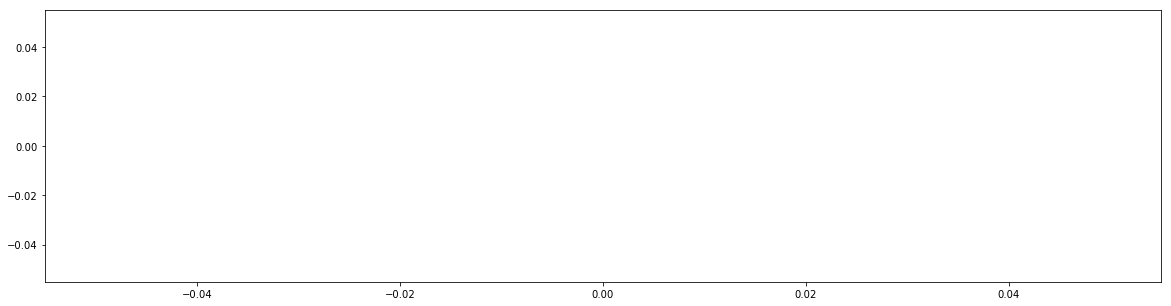

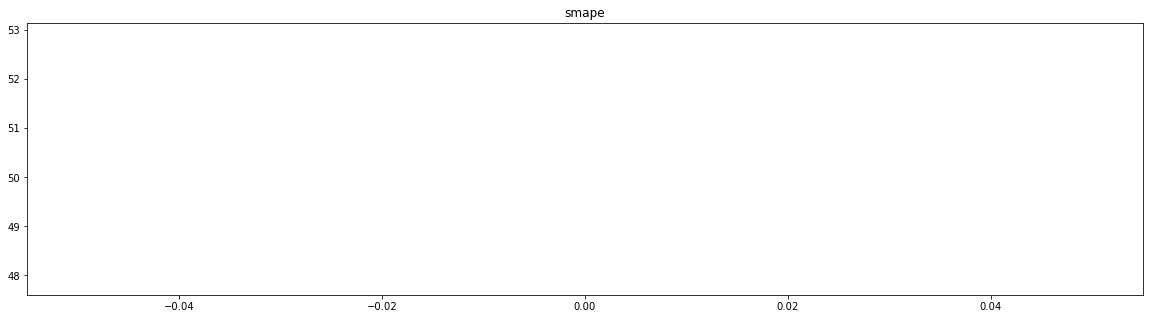

1 day prediction val: smape = 50.37595815906087, l1 = 0.6202337741851807


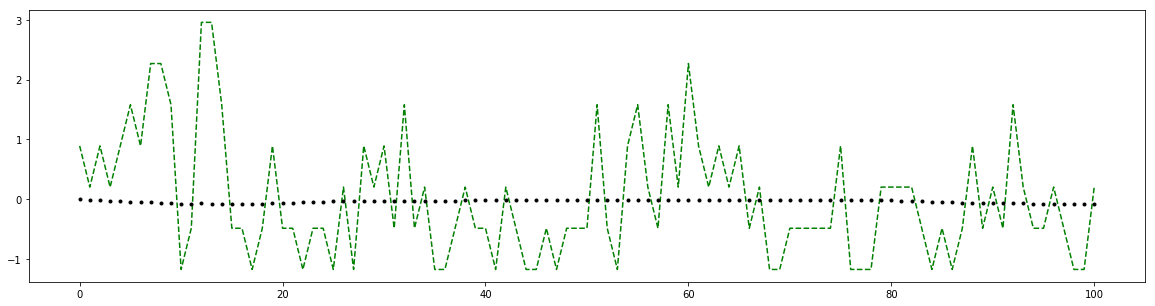

[[09/04/2017 06:20:29 PM]] [[step        0]]     [[train]]     loss: 0.00663977       [[val]]     loss: 0.76090205  
[[09/04/2017 06:20:36 PM]] [[step        9]]     [[train]]     loss: 0.51064607       [[val]]     loss: 0.5425795   
[[09/04/2017 06:20:36 PM]] saving model to ./tf-data/checkpoints/model
[[09/04/2017 06:20:37 PM]] Training ended
[[09/04/2017 06:20:37 PM]] Best validation loss of 0.5425795 at training step 9


In [15]:
reader = DataReader(
    data, fpage=fpage, fdate=fdate, 
    min_train_days=100, 
    max_train_days=200, 
    train_predict_days=60, 
    train_loss_days=60,
    
    min_val_days=250, 
    max_val_days=250, 
    val_predict_days=60, 
    val_loss_days=60,
    
    train_val_split_day=300, 
    predict_days=60,
    seed=923
)

# reader = DataReader(
#     data, fpage=fpage, fdate=fdate, 
#     min_train_days=8, 
#     max_train_days=8, 
#     train_predict_days=1, 
#     train_loss_days=1, 
#     train_val_split_day=400, 
#     seed=923
# )

# 1000 steps make an epoch
nn = WikiRNN(
    name='nn10',
    reader=reader,
    work_dir='./tf-data',
    optimizer='adam',
    learning_rate=.0005,
    batch_size=1,
    num_validation_batches=1,
    num_training_steps=10,
    early_stopping_steps=2000000,
    num_restarts=3,
    warm_start_init_step=0,
    regularization_constant=0.0,
    enable_parameter_averaging=False,
    min_steps_to_checkpoint=0,
    loss_averaging_window=1000,
    log_interval=10,

    state_size=[300, 300],
    keep_prob=1
)

def smape(true, pred, sc):
    t = (sc.inverse_transform(true.T))
    p = (sc.inverse_transform(pred.T))
    p = np.round(np.maximum(0, p))
    return (np.abs(t - p) * 200 / np.maximum(1e-10, (t + p))).reshape((-1))
    

val_gen = reader.val_batch_generator(20000)
smapes = []
    
for step in nn.fit(yield_interval=2000):
    
    val_batch_df = next(val_gen)
    feed_dict = {
        getattr(nn, placeholder_name, None): data
        for placeholder_name, data in val_batch_df.items() if hasattr(nn, placeholder_name)
    }

#     train_feed_dict.update({nn.learning_rate_var: nn.learning_rate})
    loss_l1, preds = nn.session.run(
        fetches=[nn.loss, nn.preds],
        feed_dict=feed_dict
    )
    loss_smape = smape(val_batch_df['data'][:, -reader.train_loss_days:], preds[:, -reader.train_loss_days:], sc=val_batch_df['scaler']).mean()
    smapes.append(loss_smape)
    plt.figure(figsize=(20, 5))
    plt.title('smape')
    plt.plot(smapes)
    plt.show()
    
    print('val: smape = {}, l1 = {}'.format(loss_smape, loss_l1))
    
    for i in range(1):
        idx = np.random.randint(0, 1000)
        plt.figure(figsize=(20, 5))
        
        true = val_batch_df['data'][idx, :]
        plt.plot(true, 'g--')
        pred = preds[idx, :]
        plt.plot(pred, 'k.')
        
#         loss = smape(true, pred)
#         plt.plot(loss, 'r:')
#         plt.title('loss = {}'.format(loss[-62:].mean()))
        plt.show()

In [16]:
nn.restore()
preds = nn.predict()

[[09/04/2017 06:20:44 PM]] Restoring model parameters from ./tf-data/checkpoints/model-9
INFO:tensorflow:Restoring parameters from ./tf-data/checkpoints/model-9


In [ ]:
np.save(os.path.join(root, 'pred.{}.npy'.format(name)), np.round(preds[:,-60:]))